In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, RocCurveDisplay)
from scipy.stats import randint, uniform

# Load the reduced feature set from 2.3
train_df = pd.read_csv("heart_disease_reduced_train.csv")
test_df  = pd.read_csv("heart_disease_reduced_test.csv")

X_train = train_df.drop(columns=["target"])
y_train = train_df["target"]
X_test  = test_df.drop(columns=["target"])
y_test  = test_df["target"]

X_train.shape, X_test.shape


((736, 21), (184, 21))

In [3]:
baseline_models = {
    "LogReg": LogisticRegression(max_iter=1000, solver="liblinear"),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
}

def eval_model(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    y_pred  = model.predict(Xte)
    y_proba = model.predict_proba(Xte)[:,1]
    return dict(
        Model=name,
        Accuracy=accuracy_score(yte, y_pred),
        Precision=precision_score(yte, y_pred),
        Recall=recall_score(yte, y_pred),
        F1=f1_score(yte, y_pred),
        AUC=roc_auc_score(yte, y_proba),
    )

baseline_rows = [eval_model(n, m, X_train, y_train, X_test, y_test) for n,m in baseline_models.items()]
baseline_df = pd.DataFrame(baseline_rows).sort_values("AUC", ascending=False).reset_index(drop=True)
baseline_df


,Model,Accuracy,Precision,Recall,F1,AUC
0,RandomForest,0.831522,0.838095,0.862745,0.850242,0.920074
1,SVM,0.804348,0.789474,0.882353,0.833333,0.906504
2,LogReg,0.826087,0.824074,0.872549,0.847619,0.901961
3,DecisionTree,0.728261,0.760000,0.745098,0.752475,0.726208


In [4]:
cv = 5
scoring = "roc_auc"
n_jobs = -1
RANDOM_STATE = 42

# 1) Logistic Regression (Grid)
logreg = LogisticRegression(max_iter=2000, solver="liblinear")
grid_logreg = GridSearchCV(
    estimator=logreg,
    param_grid={
        "C": [0.01, 0.1, 1, 3, 10],
        "penalty": ["l1", "l2"]
    },
    scoring=scoring, cv=cv, n_jobs=n_jobs, refit=True
)

# 2) Decision Tree (Grid)
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_dt = GridSearchCV(
    estimator=dt,
    param_grid={
        "max_depth": [None, 3, 5, 7, 10, 15],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4, 8],
        "criterion": ["gini", "entropy", "log_loss"]
    },
    scoring=scoring, cv=cv, n_jobs=n_jobs, refit=True
)

# 3) Random Forest (Randomized)
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight=None)
rand_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions={
        "n_estimators": randint(200, 800),
        "max_depth": [None, 5, 10, 15, 20, 30],
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "max_features": ["sqrt", "log2", None],
        "bootstrap": [True, False]
    },
    n_iter=40, scoring=scoring, cv=cv, n_jobs=n_jobs, random_state=RANDOM_STATE, refit=True
)

# 4) SVM (Randomized) – RBF kernel
svm = SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)
rand_svm = RandomizedSearchCV(
    estimator=svm,
    param_distributions={
        "C": uniform(0.01, 50),
        "gamma": uniform(1e-4, 1),
    },
    n_iter=40, scoring=scoring, cv=cv, n_jobs=n_jobs, random_state=RANDOM_STATE, refit=True
)

searches = {
    "LogReg": grid_logreg,
    "DecisionTree": grid_dt,
    "RandomForest": rand_rf,
    "SVM": rand_svm
}
searches


{'LogReg': GridSearchCV(cv=5,
              estimator=LogisticRegression(max_iter=2000, solver='liblinear'),
              n_jobs=-1,
              param_grid={'C': [0.01, 0.1, 1, 3, 10], 'penalty': ['l1', 'l2']},
              scoring='roc_auc'),
 'DecisionTree': GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
              param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [None, 3, 5, 7, 10, 15],
                          'min_samples_leaf': [1, 2, 4, 8],
                          'min_samples_split': [2, 5, 10, 20]},
              scoring='roc_auc'),
 'RandomForest': RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                    n_iter=40, n_jobs=-1,
                    param_distributions={'bootstrap': [True, False],
                                         'max_depth': [None, 5, 10, 15, 20, 30],
                                         'max_features': ['sqrt', 'log2', N

In [5]:
best_models = {}
tuned_rows = []

for name, search in searches.items():
    print(f"Searching best {name}…")
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_

    # Evaluate best on test set
    m = search.best_estimator_
    y_pred  = m.predict(X_test)
    y_proba = m.predict_proba(X_test)[:,1]
    tuned_rows.append(dict(
        Model=name + " (tuned)",
        BestParams=str(search.best_params_),
        Accuracy=accuracy_score(y_test, y_pred),
        Precision=precision_score(y_test, y_pred),
        Recall=recall_score(y_test, y_pred),
        F1=f1_score(y_test, y_pred),
        AUC=roc_auc_score(y_test, y_proba),
    ))

tuned_df = pd.DataFrame(tuned_rows).sort_values("AUC", ascending=False).reset_index(drop=True)
tuned_df


Searching best LogReg…
Searching best DecisionTree…
Searching best RandomForest…
Searching best SVM…


,Model,BestParams,Accuracy,Precision,Recall,F1,AUC
0,RandomForest (tuned),"{'bootstrap': True, 'max_depth': 5, 'max_featu...",0.842391,0.834862,0.892157,0.862559,0.924319
1,LogReg (tuned),"{'C': 1, 'penalty': 'l2'}",0.826087,0.824074,0.872549,0.847619,0.901961
2,SVM (tuned),"{'C': np.float64(29.630728443102125), 'gamma':...",0.809783,0.796460,0.882353,0.837209,0.900287
3,DecisionTree (tuned),"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.788043,0.818182,0.794118,0.805970,0.843257


In [6]:
# Merge (same columns for easy comparison)
b = baseline_df.assign(Type="Baseline")
t = tuned_df.drop(columns=["BestParams"]).assign(Type="Tuned")

compare_df = pd.concat([b, t], ignore_index=True)
compare_df = compare_df.sort_values(["Model","Type"]).reset_index(drop=True)
compare_df


,Model,Accuracy,Precision,Recall,F1,AUC,Type
0,DecisionTree,0.728261,0.760000,0.745098,0.752475,0.726208,Baseline
1,DecisionTree (tuned),0.788043,0.818182,0.794118,0.805970,0.843257,Tuned
2,LogReg,0.826087,0.824074,0.872549,0.847619,0.901961,Baseline
3,LogReg (tuned),0.826087,0.824074,0.872549,0.847619,0.901961,Tuned
4,RandomForest,0.831522,0.838095,0.862745,0.850242,0.920074,Baseline
5,RandomForest (tuned),0.842391,0.834862,0.892157,0.862559,0.924319,Tuned
6,SVM,0.804348,0.789474,0.882353,0.833333,0.906504,Baseline
7,SVM (tuned),0.809783,0.796460,0.882353,0.837209,0.900287,Tuned


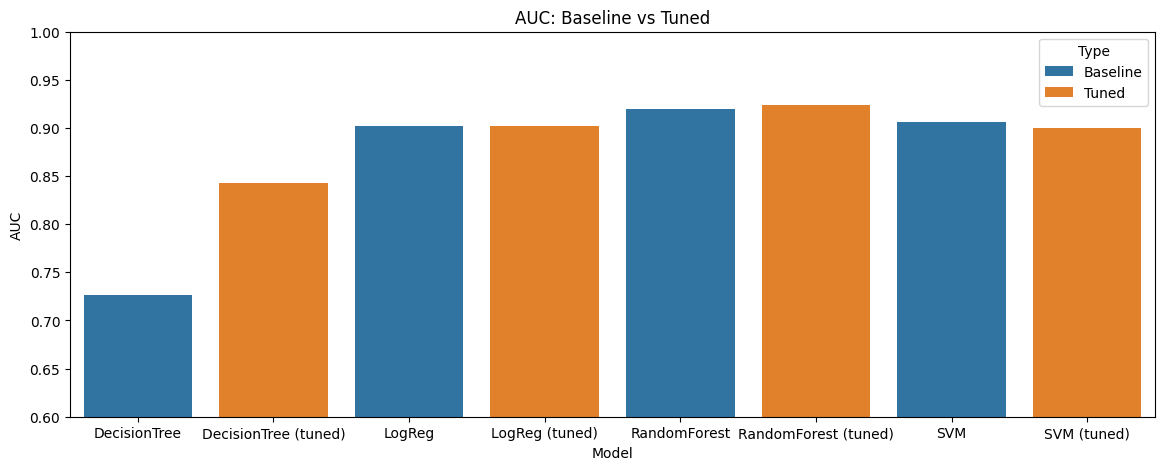

In [7]:
import seaborn as sns
plt.figure(figsize=(14,5))
sns.barplot(data=compare_df, x="Model", y="AUC", hue="Type")
plt.title("AUC: Baseline vs Tuned")
plt.ylim(0.6, 1.0)
plt.show()


In [8]:
best_row = tuned_df.iloc[0]
best_name = best_row["Model"].replace(" (tuned)","")
best_estimator = best_models[best_name]
best_name, best_row["AUC"], best_row["BestParams"]


('RandomForest',
 np.float64(0.9243185078909613),
 "{'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 469}")

In [9]:
import joblib, json, os
os.makedirs("Heart_Disease_Project/models", exist_ok=True)
os.makedirs("Heart_Disease_Project/results", exist_ok=True)

# Save best model
best_path = f"Heart_Disease_Project/models/best_model_{best_name.lower()}.joblib"
joblib.dump(best_estimator, best_path)

# Save tables
baseline_df.to_csv("Heart_Disease_Project/results/baseline_metrics.csv", index=False)
tuned_df.to_csv("Heart_Disease_Project/results/tuned_metrics.csv", index=False)
compare_df.to_csv("Heart_Disease_Project/results/baseline_vs_tuned.csv", index=False)

print("Saved best model to:", best_path)
print("Best tuned model & params:", best_name, best_row["BestParams"])


Saved best model to: Heart_Disease_Project/models/best_model_randomforest.joblib
Best tuned model & params: RandomForest {'bootstrap': True, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 11, 'n_estimators': 469}


In [11]:
import pandas as pd

results_df = pd.read_csv("supervised_model_metrics.csv")
tuned_df   = pd.read_csv("tuned_metrics.csv")

with open("Heart_Disease_Project/results/evaluation_metrics.txt", "w") as f:
    f.write("Supervised Learning Models - Final Evaluation\n")
    f.write("="*50 + "\n\n")
    f.write(results_df.to_string(index=False))
    f.write("\n\nTuned Models (2.6):\n")
    f.write(tuned_df.to_string(index=False))
    f.write("\n\nBest model: Random Forest (tuned)\n")
